# Lab 3: Bayesian PCA

### Machine Learning II, 2016

* The lab exercises should be made in groups of two people.
* The deadline for part 1 is Sunday, 15 May, 23:59.
* Assignment should be sent to taco.cohen at gmail dot com. The subject line of your email should be "[MLII2016] lab3part1_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[MLII2016] lab01\_Kingma\_Hu", the attached file should be "lab3part1\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts!
* NOTE: please write your answers directly below the question in the notebook.

## Introduction

In this lab assignment, we will implement a variational algorithm for Bayesian PCA. Unlike regular PCA based on maximization of retained variance or minimization of projection error (see Bishop, 12.1.1 and 12.1.2), probabilistic PCA defines a proper density model over observed and latent variables. We will work with a fully Bayesian model this time, which is to say that we will put priors on our parameters and will be interested in learning the posterior over those parameters. Bayesian methods are very elegant, but require a shift in mindset: we are no longer looking for a point estimate of the parameters (as in maximum likelihood or MAP), but for a full posterior distribution over the space of parameters.

The integrals involved in a Bayesian analysis are usually analytically intractable, so that we must resort to approximations. In this lab assignment, we will implement the variational method described in Bishop99. Chapters 10 and 12 of the PRML book contain additional material that may be useful when doing this exercise.

* [Bishop99] Variational Principal Components, C. Bishop, ICANN 1999 - http://research.microsoft.com/pubs/67241/bishop-vpca-icann-99.pdf

Below, you will find some code to get you started.

In [3]:
%pylab inline
import math
import cPickle, gzip

import numpy as np
import numpy.linalg
import scipy.special as sp

import matplotlib.pyplot as plt
import matplotlib.cm as plt_cm
import matplotlib.colors as plt_col
import sklearn.datasets as ds

class BayesianPCA(object):
    
    def __init__(self, X, q, a_alpha=10e-3, b_alpha=10e-3, a_tau=10e-3, b_tau=10e-3, beta=10e-3):
        self.d = X.shape[0] # number of dimensions
        self.N = X.shape[1] # number of data points
        self.q = q
        print 'dimension',self.d
        print 'data points', self.N
        self.X = X
        
        # Hyperparameters
        self.a_alpha = a_alpha
        self.b_alpha = b_alpha
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.beta = beta

        # Variational parameters
        self.means_z = np.random.randn(self.q, self.N) # called x in bishop99
        self.sigma_z = np.random.randn(self.q, self.q)
        self.means_mu = np.random.normal(0.0, 1.0, self.d)
        self.sigma_mu = np.random.randn(self.d, self.d)
        self.means_w = np.random.randn(self.d, self.q)
        self.sigma_w = np.random.randn(self.q, self.q)
        self.a_alpha_tilde = np.abs(np.random.randn(1))
        self.b_alpha_tilde = np.abs(np.random.randn(q, 1))
        self.a_tau_tilde = np.abs(np.random.randn(1))
        self.b_tau_tilde = np.abs(np.random.randn(1))
    
    def __update_z(self):
        # updating covariance matrix
        I = np.eye(self.q)
        self.sigma_z = numpy.linalg.inv(I + self.gamma_mean * self.means_w.T.dot(self.means_w))
        # updating mean ( note that mean is dependent on cov matrix computed previously)
        self.means_z = self.gamma_mean * self.sigma_z.dot(self.means_w.T).dot(self.X - self.means_mu[:, np.newaxis])
    
    def __update_mu(self):
        # updating covariance matrix
        self.sigma_mu = math.pow(self.beta + self.N * self.gamma_mean, -1)*np.eye(self.d)
        # updating mean ( note that mean is dependent on cov matrix computed previously)
        mu = np.sum(self.X - self.means_w.dot(self.means_z),1)
        self.means_mu = self.gamma_mean * self.sigma_mu.dot(mu)
    
    def __update_w(self):
        alpha_mean = self.a_alpha_tilde/self.b_alpha_tilde
        alpha_mat = np.diag(alpha_mean)
        # updating covariance matrix
        z_cov = np.zeros((self.q,self.q))
        for i in range(self.N):
            z = self.means_z[:,i]
            z = z[:,np.newaxis]
            z_cov += z.dot(z.T)
        self.sigma_w = np.linalg.inv(alpha_mat + self.gamma_mean * z_cov)
        # updating mean
        dif = self.X - self.means_mu[:, np.newaxis]
        self.means_w = (self.gamma_mean * self.sigma_w.dot(self.means_z.dot(dif.T))).T
    
    def __update_alpha(self):
        self.a_alpha_tilde = self.a_alpha + self.d/2
        self.b_alpha_tilde = self.b_alpha + np.power(np.linalg.norm(self.means_w,axis=0),2)/2

    def __update_tau(self):
        self.a_tau_tilde = self.a_tau + self.N * self.d/2
        self.b_tau_tilda = 0
        w = self.means_w
        ww = w.T.dot(w)
        mu_mean = self.means_mu
        for n in range(self.N):
            z_mean = self.means_z[:,n]
            x_n = self.X[:, n]
            self.b_tau_tilda += np.linalg.norm(x_n,ord=2)+mu_mean.T.dot(mu_mean)
            self.b_tau_tilda += np.trace(ww.dot(z_mean.dot(z_mean.T)))
            self.b_tau_tilda += 2 * mu_mean.T.dot(w).dot(z_mean)
            self.b_tau_tilda -=2*x_n.T.dot(w).dot(z_mean) - 2*x_n.T.dot(mu_mean)
        self.b_tau_tilda = self.b_tau + self.b_tau/2

    def _E_p_alpha_i(self):
        return sp.psi(self.a_alpha) - np.log(self.b_alpha)

    def _E_ln_p_alpha(self):
        q = self.q
        return q * (self.a_alpha * np.log(self.b_alpha) -
                    sp.gammaln(self.a_alpha) +
                    (self.a_alpha - 1) * self._E_p_alpha_i() -
                    self.a_alpha)

    def _E_ln_p_tau(self):
        return self.a_tau * np.log(self.b_tau) -\
               sp.gammaln(self.a_tau) +\
               (self.a_tau - 1) * self._E_tau() -\
               self.a_tau

    def _E_ln_p_mu(self):
        D = self.d
        return -0.5 - D / 2 * (np.log(2 * np.pi) + 1) + np.log(self.beta) / 2

    def _E_ln_p_w_alpha_i(self):
        return self.d / 2 * self._E_p_alpha_i() -\
            self.d / 2 * np.log(2 * np.pi) -\
            self.a_alpha / (2 * self.b_alpha) * (np.diag(self.sigma_w) + self.means_w)

    def _E_ln_p_w_alpha(self):
        return np.sum(self._E_ln_p_w_alpha_i())

    def _E_ln_p_z(self):
        D = self.d
        return self.N * (-0.5 - D / 2 * np.log(2 * np.pi) - 0.5 * np.log(2))

    def _E_tau(self):
        return self.a_tau / self.b_tau

    def _E_ln_tau(self):
        return sp.psi(self.a_tau) - np.log(self.b_tau)

    def _E_ln_p_x_z_W_mu_tau(self, X):
        acc = 0
        D = self.d
        for n in range(self.N):
            diff = X[:, n] - self.means_w.dot(self.means_z[:, n]) - np.squeeze(self.means_mu)
            acc += -D / 2 * np.log(2 * np.pi) - 0.5 * np.log(D) + 0.5 * self._E_ln_tau() -\
                self._E_ln_tau() / 2 * (np.dot(diff.T, diff))
        return acc

    def _E_Q_Z(self):
        return self.N * (- self.d / 2 - self.d / 2 * np.log(2 * np.pi) -
                         0.5 * np.log(np.abs(np.trace(self.sigma_z))))

    def _E_Q_mu(self):
        return -self.d / 2 - self.d / 2 * np.log(2 * np.pi) -\
               0.5 * np.log(np.abs(np.trace(self.sigma_mu)))

    def _E_Q_W(self):
        return self.d * (-self.d / 2 - self.d / 2 * np.log(2 * np.pi) -
                         0.5 * np.log(np.abs(np.trace(self.sigma_w))))

    def _E_Q_alpha(self):
        return np.sum(self.a_alpha_tilde * np.log(self.b_alpha_tilde) -
                      sp.gammaln(self.a_alpha_tilde) + (self.a_alpha_tilde - 1) *
                      (sp.psi(self.a_alpha_tilde) - np.log(self.b_alpha_tilde)) -
                      self.a_alpha_tilde)

    def _E_Q_tau(self):
        return np.sum(self.a_tau_tilde * np.log(self.b_tau_tilde) -\
                sp.gammaln(self.a_tau_tilde) + (self.a_tau_tilde - 1) *\
                (sp.psi(self.a_tau_tilde) - np.log(self.b_tau_tilde)) -\
                self.a_tau_tilde)

    def L(self, X):
        return self._E_ln_p_alpha() +\
            self._E_ln_p_tau() +\
            self._E_ln_p_mu() +\
            self._E_ln_p_w_alpha() +\
            self._E_ln_p_z()+\
            self._E_Q_Z() -\
            self._E_Q_mu() -\
            self._E_Q_W() -\
            self._E_Q_alpha() -\
            self._E_Q_tau() -\
            self._E_ln_p_x_z_W_mu_tau(X)

    # returns the squared difference error between reconstructed and the actual data
    def mse(self):
        d = self.X - self.transform()
        return np.linalg.norm(d, ord=2)
    
    def transform(self):
        return self.means_w.dot(self.means_z) + self.means_mu[:,np.newaxis]
    
    def fit(self):
        # compute gamma mean here as it's used in later updated
        self.gamma_mean = self.a_tau / self.b_tau
        self.__update_mu()
        self.__update_w()
        self.__update_z()  
        self.__update_alpha() 
        self.__update_tau()

Populating the interactive namespace from numpy and matplotlib


### 1. The Q-distribution (5 points)

In variational Bayes, we introduce a distribution $Q(\Theta)$ over parameters / latent variables in order to make inference tractable. We can think of $Q$ as being an approximation of a certain distribution. What function does $Q$ approximate, $p(D|\Theta)$, $p(\Theta|D)$, $p(D, \Theta)$, $p(\Theta)$, or $p(D)$, and how do you see that from the equation $\ln p(D) = \mathcal{L}(Q) + \mathrm{KL}(Q||P)$? (Hint: see eq. 11 in Bishop99)

Answer
-------

Q approximates p(\theta|D) since we are minimizing Kullback-Leibler divergence between the approximating distribution $Q(\theta)$ and the true posterior $p(\theta|D)$ in the eq.11 (Bishop99).

## Score 5/5

### 2. The mean-field approximation (15 points)

Equation 13 from [Bishop99] is a very powerful result: assuming only that $Q(\Theta)$ factorizes in a certain way (no assumptions on the functional form of the factors $Q_i$!), we get a set of coupled equations for the $Q_i$.

However, the expression given in eq. 13 for Q_i contains a small mistake. Starting with the expression for the lower bound $\mathcal{L}(Q)$, derive the correct expression (and include your derivation). You can proceed as follows: first, substitute the factorization of $Q$ (eq. 12) into the definition of $\mathcal{L}(Q)$ and separate $\mathcal{L}(Q)$ into $Q_i$-dependent and $Q_i$-independent terms. At this point, you should be able to spot the expectations $\langle\cdot\rangle_{k \neq i}$ over the other $Q$-distributions that appear in Bishop's solution (eq. 13). Now, keeping all $Q_k, k \neq i$ fixed, maximize the expression with respect to $Q_i$. You should be able to spot the form of the optimal $\ln Q_i$, from which $Q_i$ can easily be obtained.

Answer
------
Bishop PRML (10.3):
$$ \mathcal{L}(Q) = \int Q(\theta)\ln\dfrac{p(\theta,D)}{Q(\theta)}d\theta $$

Bishop99 (12):

$$ Q(\theta) = \prod_i Q_i(\theta_i) $$

Bishop PRML (10.6):

$$
\mathcal{L}(Q) = \int Q(\theta)\bigg(\ln p(\theta, D) - \ln Q(\theta)\bigg)d\theta\\
=\int \prod_i Q_i(\theta_i)\bigg(\ln p(\theta,D) - \sum_j \ln Q_i(\theta_i)\bigg)d\theta\\
=\int Q_k(\theta_k)\bigg[\int\bigg(\prod_{i \neq k} Q_i(\theta_i)\bigg)\ln p(\theta,D)d\theta_i\bigg]d\theta_k - \int Q_k(\theta_k)\ln Q_k(\theta_k)d\theta_k + const
$$

$$
= \int Q_k(\theta_k)\ln\widetilde{p}(\theta_k,D)d\theta_k - \int Q_k(\theta_k)\ln Q_k(\theta_k)d\theta_k + const
$$

where we denote:

$$
\ln\widetilde{p}(\theta_k,D) = E_{i\neq k}[\ln p(\theta, D)] + const
$$

Maximizing $\mathcal{L}(Q)$ is equivalent to minizing the Kullback-Leibler divergence occured when $Q_k(\theta_k) = \widetilde{p}(\theta_k, D)$. Consequently:

$$
\ln q_k^{*}(\theta_k) = = E_{i\neq k}[\ln p(\theta, D)] + const
$$

After taking the exponential of both sides and normalizing we get:

$$
Q_k^{*}(\theta_k) = \dfrac{\exp{E_{i\neq k}[\ln p(\theta, D)]}}{\int\exp{E_{i\neq k}[\ln p(\theta, D)]}d\theta_k}
$$

Consequently a small mistake in the paper was just in indexes in the denominator.

## Score 15/15

### 3. The log-probability (10 points)

Write down the log-prob of data and parameters, $\ln p(\mathbf{X}, \mathbf{Z}, \mathbf{W}, \mathbf{\alpha}, \tau, \mathbf{\mu})$, in full detail (where $\mathbf{X}$ are observed, $\mathbf{Z}$ is latent; this is different from [Bishop99] who uses $\mathbf{T}$ and $\mathbf{X}$ respectively, but $\mathbf{X}$ and $\mathbf{Z}$ are consistent with the PRML book and are more common nowadays). Could we use the log-prob to assess the convergence of the variational Bayesian PCA algorithm? If yes, how? If no, why not?

Answer
------
**WARNING**: Variables may be a bit inconsistent since Bishop didn't keep the same notation in different his papers, and some variables have similar name (like d - as dimension and d as a parameter of the Gamma function), therefore some variables will be differentiate contextually.

The probability of data and parameters is (derived from the graphical model in Figure 1 (Bishop99):

$$
p(X,Z,W,\alpha,\tau,\mu) = p(\alpha)p(\tau)p(\mu)p(W|\alpha)p(Z)p(X|Z,W,\tau,\mu)\\
= p(\alpha)p(\tau)p(\mu)p(W|\alpha)\prod_{n=1}^N p(z_n)\prod_{n=1}^N p(x_n|z_n, W,\tau,\mu)
$$

Consequently log-prob will be:

$$
\ln p(X,Z,W,\alpha,\tau,\mu) = \ln p(\alpha) + \ln p(\tau) + \ln p(\mu) + \ln p(W|\alpha) + \sum_{n=1}^N \ln p(z_n)  + \sum_{n=1}^N \ln p(x_n|z_n, W,\tau,\mu)
$$

where (Bishop99, p 511):

$$
p(\alpha) = \prod_{i=1}^q \Gamma(\alpha_i|a,b)
$$

$$
p(\tau) = \Gamma(\tau|c,d)
$$

$$
p(\mu) = \mathcal{N}(\mu|0,\beta^{-1}I)
$$

$$
p(W|\alpha) = \prod_{i=1}^q (\dfrac{\alpha_i}{2\pi})^{d/2}\exp(-\dfrac{1}{2}\alpha_i||w_i||^2)
$$

Bishop99 (2, 3):

$$p(z_n) = \mathcal{N}(z_n|0,I)$$

$$p(x_n|z_n) = \mathcal{N}(x_n|Wz_n + \mu, \tau^{-1}I)$$

Consequently:

$$ \ln p(X,Z,W,\alpha,\tau,\mu) = \sum_{i=1}^q\ln\Gamma(\alpha_i|a,b) + \ln\Gamma(\tau|c,d) + \ln\mathcal{N}(\mu|0,\beta^{-1}I) +\sum_{i=1}^q \ln \bigg[(\dfrac{\alpha_i}{2\pi})^{d/2}\exp(-\dfrac{1}{2}\alpha_i||w_i||^2)\bigg] + \sum_{n=1}^N\ln \mathcal{N}(z_n|0,I) + \sum_{n=1}^N \ln\mathcal{N}(x_n|Wz_n + \mu, \tau^{-1}I)$$

where:

$$
\ln\Gamma(\alpha_i|a,b) = \ln\bigg[\dfrac{1}{\Gamma(a)}b^a\alpha_i^{a-1}e^{-b\alpha_i}\bigg] = a\ln b + (a-1)\ln\alpha_i - b\alpha_i - \ln\Gamma(a)
$$

$$
\ln\Gamma(\tau|c,d) = \ln\bigg[\dfrac{1}{\Gamma(c)}d^c \tau^{c-1}e^{-d\tau}\bigg] = c\ln d + (c-1)\ln\tau - d\tau - \ln\Gamma(c)
$$

$$
\ln\mathcal{N}(\mu|0,\beta^{-1}I) = \ln\bigg[\dfrac{1}{(2\pi)^{D/2}}\dfrac{1}{|\beta^{-1}I|^{1/2}}\exp(-\dfrac{1}{2}\mu^T(\beta^{-1}I)^{-1}\mu)\bigg]\\
= - \dfrac{1}{2}\mu^T\beta\mu - \dfrac{D}{2}\ln(2\pi) - \dfrac{D}{2} - \dfrac{1}{2}\ln(\beta^{-1})
$$

$$
\ln \bigg[(\dfrac{\alpha_i}{2\pi})^{d/2}\exp(-\dfrac{1}{2}\alpha_i||w_i||^2)\bigg] = \dfrac{d}{2}\ln\alpha_i - \dfrac{d}{2}\ln(2\pi)-\dfrac{1}{2}\alpha_i||w_i||^2
$$

$$
\ln \mathcal{N}(z_n|0,I) = -\dfrac{1}{2}z_n^Tz_n - \dfrac{D}{2}\ln(2\pi) - \dfrac{1}{2}\ln 2
$$

$$
\ln\mathcal{N}(x_n|Wz_n + \mu, \tau^{-1}I) = -\dfrac{1}{2}(x_n - Wz_n - \mu)^T\tau(x_n - Wz_n-\mu) - \dfrac{D}{2}\ln(2\pi) - \dfrac{1}{2}\ln(D\tau^{-1})
$$

$$
\ln p(X,Z,W,\alpha,\tau,\mu) = (a-1)\sum_{i=1}^q\ln\alpha_i - b\sum_{i=1}^q\alpha_i + (c-1)\ln\tau -d\tau -\dfrac{1}{2}\mu^T\beta\mu + \dfrac{d}{2}\sum_{i=1}^q\ln\alpha_i - \dfrac{1}{2}\sum_{i=1}^q \alpha_i||w_i||^2 - \dfrac{1}{2}\sum_{n=1}^N z_n^Tz_n - \dfrac{1}{2}\sum_{n=1}^N(x_n - Wz_n -\mu)^T\tau(x_n-Wz_n-\mu) - \dfrac{1}{2}\sum_{n=1}^N\ln(\tau^{-1}) + const\\
= (a-1 + \dfrac{d}{2})\sum_{i=1}^q\ln\alpha_i - b\sum_{i=1}^d\alpha_i + (c-1 + \dfrac{N}{2})\ln\tau -d\tau -\dfrac{1}{2}\beta||\mu||^2 - \dfrac{1}{2}\sum_{i=1}^q \alpha_i||w_i||^2 - \dfrac{1}{2}\sum_{n=1}^q ||z_n||^2 - \dfrac{1}{2}\tau\sum_{n=1}^q||x_n - Wz_n -\mu||^2 + const\\
$$

We cannot access the convergence of the variational Bayesian PCA algorithm using the log-prob since we have many parameters to optimize and to maximize the probability of data p(D) we have to integrate first over all parameters that are analytically intractable (Bishop99, Section 4, p 511).

## Score 10/10

### 4. The lower bound $\mathcal{L}(Q)$ (25 points)

Derive an expression for the lower bound $\mathcal{L}(Q)$ of the log-prob $\ln p(X)$ for Bayesian PCA, making use of the factorization (eq. 12) and the form of the Q-distributions (eq. 16-20) as listed in [Bishop99]. Show your steps. Implement this function.

The following result may be useful:

For $x \sim \Gamma(a,b)$, we have $\langle \ln x\rangle = \ln b + \psi(a)$, where $\psi(a) = \frac{\Gamma'(a)}{\Gamma(a)}$ is the digamma function (which is implemented in numpy.special).

Answer
------
**WARNING**: Variables may be a bit inconsistent since Bishop didn't keep the same notation in different his papers, and some variables have similar name (like d - as dimension and d as a parameter of the Gamma function), therefore some variables will be differentiate contextually.

$$
\mathcal{L}(Q) = \int Q(\theta)\bigg(\ln p(X, Z, W, \alpha, \tau, \mu) - \ln Q(\theta)\bigg)d\theta\\
=\int \prod_i Q_i(\theta_i)\bigg(\ln p(X, Z, W, \alpha, \tau, \mu) - \sum_j \ln Q_i(\theta_i)\bigg)d\theta\\
=\int Q(Z)Q(W)Q(\alpha)Q(\tau)Q(\mu)\bigg(\ln p(X, Z, W, \alpha, \tau, \mu) - \bigg[\ln Q(Z) + \ln Q(W) + \ln Q(\alpha) + \ln Q(\tau) + \ln Q(\mu)\bigg]\bigg)dZ dW d\alpha d\tau d\mu\\
= \int \ln p(X, Z, W, \alpha, \tau, \mu)\prod_{k}Q(\theta_k)d\theta - \sum_{i}\bigg[\int Q(\theta_i)\ln Q(\theta_i) d\theta_i\bigg]\prod_{k\neq i}\bigg[\int Q(\theta_k)d\theta_{k\neq i}\bigg]
$$

Following Bishop 10.70:

$$
\int \ln p(X, Z, W, \alpha, \tau, \mu)\prod_{k}Q(\theta_k)d\theta = \int \bigg(\ln p(\alpha) + \ln p(\tau) + \ln p(\mu) + \ln p(W|\alpha) + \sum_{n=1}^N \ln p(z_n)  + \sum_{n=1}^N \ln p(x_n|z_n, W,\tau,\mu)\bigg)Q(Z)Q(W)Q(\alpha)Q(\tau)Q(\mu)dZdW d\alpha d\tau d\mu\\
= \int\ln p(\alpha)Q(\alpha)d\alpha + \int\ln p(\tau)Q(\tau)d\tau + \int\ln p(\mu)Q(\mu)d\mu + \int\ln p(W|\alpha)Q(W)Q(\alpha)dWd\alpha + \sum_{n=1}^N\int\ln p(z_n)Q(z_n)dz_n + \sum_{n=1}^N\int\ln p(x_n|z_n, W,\tau,\mu)Q(z_n)Q(W)Q(\tau)Q(\mu)dz_n dW d\tau d\mu\\
= \langle\ln p(\alpha)\rangle + \langle\ln p(\tau)\rangle + \langle\ln p(\mu)\rangle + \sum_{i=1}^d\langle\ln p(w_i|\alpha_i)\rangle + \sum_{n=1}^N\langle\ln p(z_n)\rangle + \sum_{n=1}^N \langle\ln p(x_n|z_n,W,\mu,\tau)\rangle
$$

$$
\langle\ln p(\alpha)\rangle = \sum_{i=1}^q\langle p(\alpha_i)\rangle = \sum_{i=1}^q\langle a\ln b + (a-1)\ln\alpha_i - b\alpha_i - \ln\Gamma(a)\rangle = \sum_{i=1}^q (a\ln b - \ln\Gamma(a) + (a-1)(\psi(a)-\ln b) - a)\\
= q(a\ln b - \ln\Gamma(a) + (a-1)(\psi(a)-\ln b) - a)
$$

$$
\langle\ln p(\tau)\rangle = \langle c\ln d + (c-1)\ln\tau - d\tau - \ln\Gamma(c) \rangle = c\ln d - \ln\Gamma(c) + (c-1)(\psi(c) - \ln d) - c
$$

$$
\langle\ln p(\mu)\rangle = \langle\mathcal{N}(\mu|0,\beta^{-1}I)\rangle = \langle- \dfrac{1}{2}\beta||\mu||^2 - \dfrac{D}{2}\ln(2\pi) - \dfrac{D}{2} + \dfrac{1}{2}\ln(\beta) \rangle = - \dfrac{1}{2}\beta\beta^{-1} -\dfrac{D}{2}(\ln(2\pi) + 1) + \dfrac{1}{2}\ln\beta\\
= - \dfrac{1}{2} -\dfrac{D}{2}(\ln(2\pi) + 1) + \dfrac{1}{2}\ln\beta
$$


$$
\langle\ln p(w_i|\alpha_i)\rangle = \langle\dfrac{d}{2}\ln\alpha_i - \dfrac{d}{2}\ln(2\pi)-\dfrac{1}{2}\alpha_i||w_i||^2\rangle = \dfrac{d}{2}(\psi(a) - \ln b) - \dfrac{d}{2}\ln(2\pi) - \dfrac{1}{2}\langle\alpha_i\rangle\langle||w_i||^2\rangle\\
= \dfrac{d}{2}(\psi(a) - \ln b) - \dfrac{d}{2}\ln(2\pi) - \dfrac{1}{2}\dfrac{a}{b}(cov(w_i, w_i) + \langle w_i\rangle^T\langle w_i\rangle)\\
= \dfrac{d}{2}(\psi(a) - \ln b) - \dfrac{d}{2}\ln(2\pi) - \dfrac{1}{2}\dfrac{a}{b}(\Sigma_{w_i} + m_{w_i})
$$

where here we denote $m_{w_i}$ as an i-th element of the mean $m^w$:

$$
m_w = \langle\tau\rangle\Sigma_w\sum_{n=1}^N\langle z_n\rangle(x_n - \langle\mu\rangle) = \langle\tau\rangle\Sigma_w\sum_{n=1}^N\langle z_n\rangle x_n 
$$

and we denote $\Sigma_{w_i}$ as an i-th element of the diagonal of covariance matrix $\Sigma^w$:

$$
\Sigma_w = (diag(\alpha) + \langle \tau\rangle\sum_{n=1}^N\langle z_n z_n^T\rangle)^{-1}
$$

Knowing that:

$$
\langle\tau\rangle = \dfrac{c}{d}
$$

$$
\langle\mu\rangle = 0
$$

$$
\langle z_n \rangle = 0
$$

$$
m_z^{(n)} = \langle\tau\rangle \Sigma_x\langle W^T\rangle(x_n - \langle\mu\rangle) = \langle\tau\rangle \Sigma_z\langle W^T\rangle x_n
$$

$$
\Sigma_z = (I + \langle \tau\rangle\langle W^TW\rangle)^{-1}
$$

$$
\langle z_n z_n^T\rangle =  \Sigma_z + m_z^{(n)}{m_z^{(n)}}^T
$$

$$
\langle W \rangle = m_w
$$

<!-- TODO: Check that -->
$$
\langle W^TW \rangle = \Sigma_w
$$

$$
\langle \ln \tau \rangle = \psi(c) - \ln(d)
$$

$$
\langle\ln p(z_n)\rangle = \langle -\dfrac{1}{2}z_n^Tz_n - \dfrac{D}{2}\ln(2\pi) - \dfrac{1}{2}\ln 2 \rangle = -\dfrac{1}{2}- \dfrac{D}{2}\ln(2\pi) - \dfrac{1}{2}\ln 2
$$

$$
\langle\ln p(x_n|z_n,W,\mu,\tau)\rangle = \langle -\dfrac{1}{2}\tau||x_n - Wz_n - \mu||^2 - \dfrac{D}{2}\ln(2\pi) - \dfrac{1}{2}\ln D + \dfrac{1}{2}\ln\tau \rangle = - \dfrac{D}{2}\ln(2\pi) - \dfrac{1}{2}\ln D + \dfrac{1}{2}\langle\ln\tau \rangle - \dfrac{1}{2}\langle\tau\rangle\langle||x_n - Wz_n - \mu||^2\rangle
$$

Applying Matrix Cookbook [380] we have:
$$
\langle||x_n - Wz_n - \mu||^2\rangle = \langle(Wz_n + \mu - x_n)^TI(Wz_n + \mu - x_n)\rangle = (M_wm_z^{(n)} +m_\mu - x_n)^TI(M_wm_z^{(n)} +m_\mu - x_n) + Tr(\Sigma_w\Sigma_z + \Sigma_\mu)
$$

$$
\sum_{i}\bigg[\int Q(\theta_i)\ln Q(\theta_i) d\theta_i\bigg]\prod_{k\neq i}\bigg[\int Q(\theta_k)d\theta_{k\neq i}\bigg] = \sum_i \langle\ln Q(\theta_i)\rangle = \sum_{n=1}^N \langle\ln Q(z_n) \rangle + \langle\ln Q(\mu)\rangle + \langle \ln Q(W) \rangle + \sum_{i=1}^q \langle \ln Q(\alpha_i)\rangle + \langle \ln Q(\tau) \rangle
$$

Applying Matrix Cookbook [380] we have:

$$
\langle \ln Q(z_n)\rangle = -\dfrac{D}{2} - \dfrac{D}{2}\ln(2\pi) - \dfrac{1}{2}\ln(Tr(\Sigma_z))
$$

$$
\langle \ln Q(\mu) \rangle = -\dfrac{D}{2} - \dfrac{D}{2}\ln(2\pi) - \dfrac{1}{2}\ln(Tr(\Sigma_\mu))
$$

$$
\langle \ln Q(W) \rangle = \sum_{k=1}^d (-\dfrac{D}{2} - \dfrac{D}{2}\ln(2\pi) - \dfrac{1}{2}\ln(Tr(\Sigma_w)))
$$

$$
\langle \ln Q(\alpha_i)\rangle = \langle \widetilde{a}_\alpha\ln \widetilde{b}_{\alpha i} - \ln\Gamma(\widetilde{a}_\alpha) + (\widetilde{a}_\alpha-1)(\psi(\widetilde{a}_\alpha)-\ln \widetilde{b}_{\alpha i}) - \widetilde{a}_\alpha\rangle
$$

$$
\langle \ln Q(\tau)\rangle = \langle \widetilde{a}_\tau\ln \widetilde{b}_\tau - \ln\Gamma(\widetilde{a}_\tau) + (\widetilde{a}_\tau-1)(\psi(\widetilde{a}_\tau)-\ln \widetilde{b}_\tau) - \widetilde{a}_\tau\rangle
$$

where:

$$
\widetilde{a}_{\alpha} = \widetilde{a}_{\alpha} + \dfrac{d}{2}
$$

$$
\widetilde{b}_{\alpha i} = \widetilde{b}_{\alpha} + \dfrac{\langle ||w_i||^2 \rangle}{2}
$$

$$
\widetilde{\alpha}_\tau = \alpha_\tau + \dfrac{Nd}{2}
$$

$$
\widetilde{\beta}_\tau = \beta_\tau + \dfrac{1}{2}\sum_{n=1}^N\{||z_n||^2 + \langle||\mu||^2\rangle + Tr(\langle W^TW\rangle\langle z_n z_n^T \rangle) + 2\langle\mu^T\rangle\langle W\rangle\langle z_n\rangle - 2x_n^T\langle W\rangle\langle z_n\rangle - 2x_n^T\langle\mu\rangle\}
$$

## Score 25/25

### 5. Optimize variational parameters (50 points)
Implement the update equations for the Q-distributions, in the __update_XXX methods. Each update function should re-estimate the variational parameters of the Q-distribution corresponding to one group of variables (i.e. either $Z$, $\mu$, $W$, $\alpha$ or $\tau$).

Hint: if you run into numerical instabilities resulting from the gamma function use the gammaln function from numpy.special.

## Score 30/50

The code looks reasonable, but the experiments below don't show the expected behaviour (we would expect some columnd of means_w to go to zero), so there are still some bugs in the code.

### 6. Learning algorithm (10 points)
Implement the learning algorithm described in [Bishop99], i.e. iteratively optimize each of the Q-distributions holding the others fixed.

What would be a good way to track convergence of the algorithm? Implement your suggestion.

Test the algorithm on some test data drawn from a Gaussian with different variances in orthogonal directions. 

##Answer
We could use the difference between our reconstructed data and the actual data, e.g. the L2 norm of the difference. Alternatively,
we could use the lowerbound log-likelihood to track the convergence of the model.

In [4]:
def plot_mse(mse):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mse, linewidth=2, marker='s',markersize=5, markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('MSE')


dimension 10
data points 1000


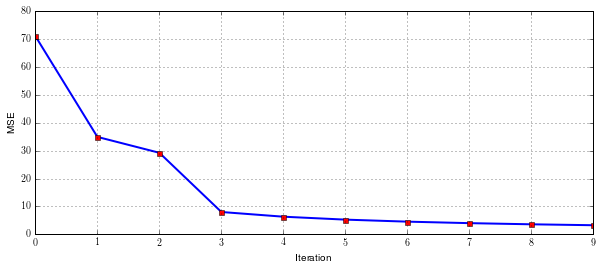

[[-1.83 -0.14 -0.06  0.86 -0.51 -0.25  1.83  2.57  0.66 -2.79]
 [-1.59 -0.82 -0.09  1.43 -1.05  0.64  1.55 -1.24  2.65  2.  ]
 [ 1.02 -0.11  0.07  2.52 -2.15 -0.94 -2.39 -0.02  0.64 -0.92]
 [-4.04  0.41  0.08 -0.79 -0.55 -0.67 -1.98 -0.45 -1.32  0.45]
 [ 0.29  0.74 -0.33 -2.14 -1.46 -0.48  0.72 -2.87  0.98 -2.14]
 [ 0.2  -0.58  0.06 -2.33  0.26  0.28 -2.07  1.92  3.17  0.24]
 [-0.44  1.23  3.05  1.18  2.56 -0.99 -0.75 -1.19  1.34 -1.19]
 [ 0.14  3.56  1.35 -0.1  -1.46  1.73  0.36  1.07  0.02  0.89]
 [-0.55 -0.86  1.25  0.63  0.49  3.65 -1.21 -0.9  -0.29 -1.75]
 [-0.56  1.45 -3.51  1.34  2.16  0.2  -1.15 -0.65  0.91 -1.13]]
[ 24.1705834   18.81065222  25.14700604  23.35846729  22.04359943
  19.39933627  23.66855832  24.05666249  23.3433874   24.03297643]
[ 22.5746659   21.74654912  19.84830408  23.94587438  22.01239955
  24.04756201  25.0653218   21.73571305  21.96592851  25.08891088]


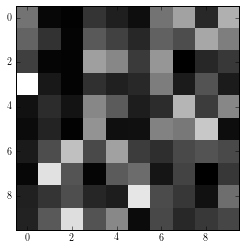

In [17]:
def run_on_gaussian_data(d=2,q=1,N=100000,maxit=10):
    # generating data
    #C = 10*np.abs(np.random.rand(d,d))
    #mu = 10*np.abs(np.random.rand(d,1))
    d = 10
    q = 10
    C = np.diag([5, 4, 3, 5, 5, 5, 1, 1, 1, 1])
    mu = np.zeros(10)
    X = np.random.multivariate_normal(mu.flatten(), C, size=N)

    # running BPCA
    bppca = BayesianPCA(X.T,q)
    mse = []
    for i in xrange(maxit):
        bppca.fit()
        mse.append(bppca.mse())
    transformed = bppca.transform()

    # plotting (works only on 2d data)
    if d ==2:
        fig = plt.figure(num=None, figsize=(26, 12), dpi=80, facecolor='w', edgecolor='k')
        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(312)
        ax1.scatter(X[:,0], X[:,1], s=20)
        ax1.set_title("Original data")
        ax2.scatter(transformed[:,0], transformed[:,1], s=20)
        ax2.set_title("Transformed data")
    plot_mse(mse)
    plt.show()
    
    print np.round(bppca.means_w, 2)
    plt.imshow(np.abs(bppca.means_w), 'gray', interpolation='nearest')
    
    print np.sum(bppca.means_w ** 2, axis=0)
    print np.sum(bppca.means_w ** 2, axis=1)

run_on_gaussian_data(d=100,N=1000,q=30)

## Score 10/10

### 7. PCA Representation of MNIST (10 points)

Download the MNIST dataset from here http://deeplearning.net/tutorial/gettingstarted.html (the page contains python code for loading the data). Run your algorithm on (part of) this dataset, and visualize the results.


In [12]:
# plots for MNIST dataset
def plot_bppca_digits(X, q=700, maxit=7):
    # initial plot
    fig0, ax0 = plt.subplots(nrows=2, ncols=5, figsize=[15, 10])
    ax0 = ax0.flatten()
    for i in xrange(10):
        ax0[i].matshow(X[:, i].reshape(28,28), cmap=plt_cm.gray)
    fig0.suptitle('Initial images', fontsize=20)
    fig0.tight_layout()
    np.random.seed(0)
    bppca = BayesianPCA(X, q)

    mse = [bppca.mse()]
    
    for i in xrange(maxit):
        print("iteration "+str(i+1))
        bppca.fit()
        mse.append(bppca.mse())
    # transformed image
    transformed = bppca.transform()
    fig1, ax1 = plt.subplots(nrows=2, ncols=5, figsize=[15, 10])
    ax1 = ax1.flatten()
    for i in xrange(10):
        ax1[i].matshow(transformed[:, i].reshape(28,28), cmap=plt_cm.gray)
    fig1.suptitle('Reconstructed images with q = '+str(q), fontsize=20)
    fig1.tight_layout()
    plot_mse(mse)
    plt.show()
    return bppca

dimension 784
data points 15
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7


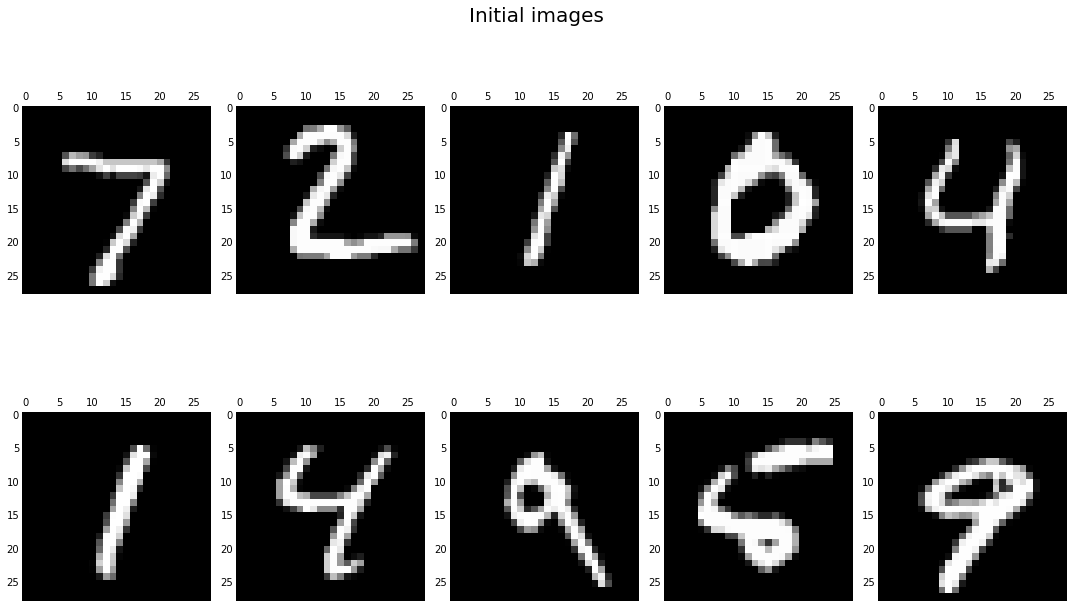

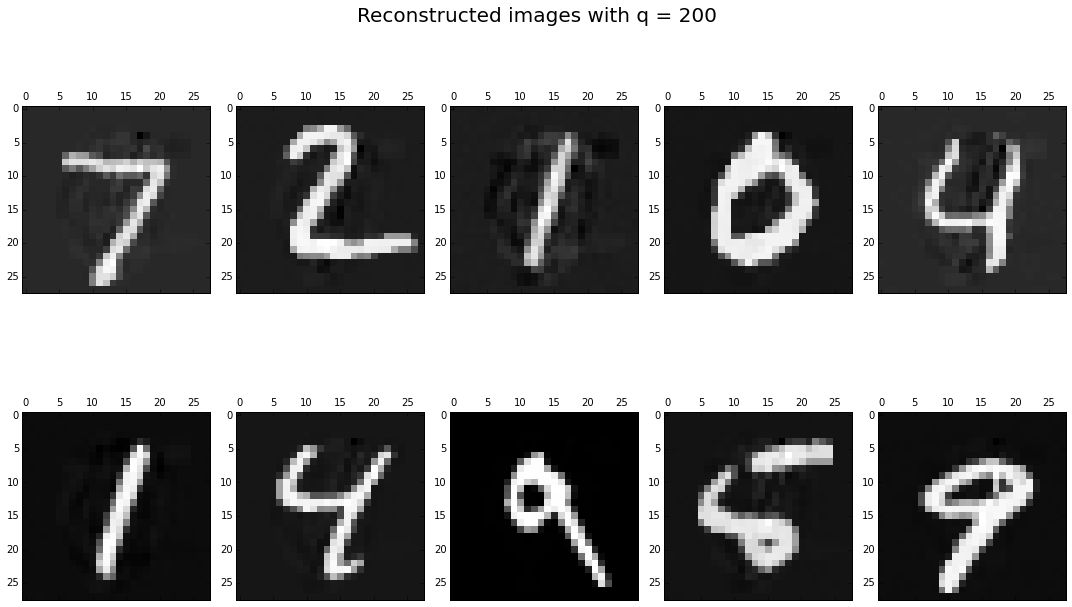

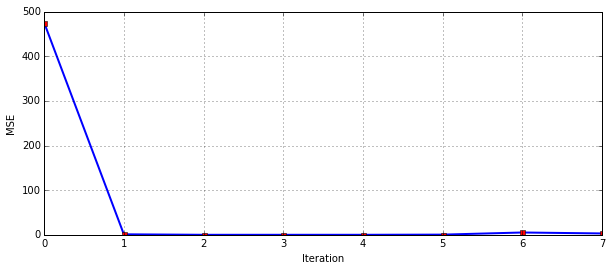

In [13]:
# loading digits
f = gzip.open('mnist.pkl.gz')
train_set, valid_set, test_set = cPickle.load(f)
f.close()
plot_bppca_digits(test_set[0][0:15].T,q=200)

## Score 10/10